# Assignment 4
*By Ryan Cox*

In [114]:
using LinearAlgebra
using Plots.Measures
using MAT

## Q1

In [ ]:
"""
Structure for storing results of the tomography fitting.
"""
struct SVDAnalysis
     G::Matrix
     d::Vector # Observed
     dStd::Real
     m::Vector # Estimated
     covM::Matrix
     fig::Any # plot
     p::Integer
end


"""
Use singular value decomposition to solve an inverse problem described by G.
Based on TomographyFit() written for Assignment 3.

Parameters
        G::Matrix - Model kernel
        dObs::Vector - Observed data
        dStd::Real - Standard deviation of data
        p::Integer - Number of singular values considered

Returns as SVDAnalysis
"""
function SVDFit(G::Matrix, dObs::Vector, dStd::Real, p::Integer=-1)::SVDAnalysis
    # Decompose kernel G into U, S and V such that G = U * Diagonal(S) * Vt
    decomposition = svd(G)
    U = decomposition.U
    S = decomposition.S # The book calls it L. It is provided here already as a vector of the singular values.
    V = decomposition.V
    Vt = decomposition.Vt # transpose of V

    p = p < 0 ? length(S) : p # Use length(S) for p unless p specifically set in function call
    Sp = S[1:p] # Truncate component matrices
    Up = U[:,1:p]
    Vp = V[:,1:p]

    # Estimate parameters, their covariance
    mEst = Vp * ((transpose(Up) * dObs) ./ Sp)
    covM = dStd^2 * Vp * (Diagonal(Sp)^(-2)) * transpose(Vp)

    # prepare plots
    fig = plot(dObs, seriestype=:scatter, yerror=dStd, markerstrokecolor=:auto, label="Observed data", xlabel="index", ylabel="time (s)", title=label)
    fig = plot!(G * mEst, label="Predicted data")

    SVFAnalysis(G, dObs, dStd, mEst, covM, fig, p)
end

First let us load our data. We'll then plot all the seismograms together, just to demonstrate their similarity. This graph is useless for anything else, although it has a certain asthetic appeal.

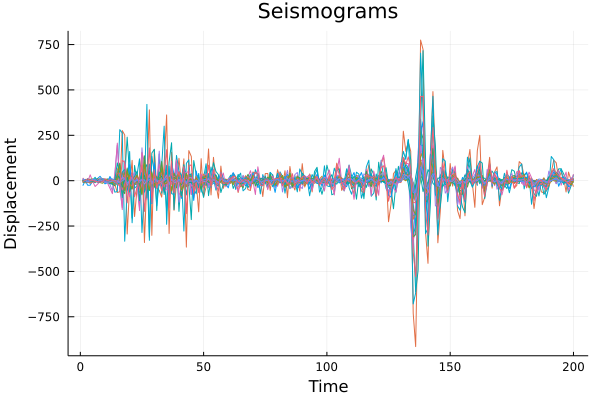

In [90]:
seismograms = matread("C:\\Users\\Ryan's PC\\github\\math322-inverse-theory\\seismograms.mat.mat")["seismograms"]
# I assume the format of the data is that each row is single seismogram.
# Each value is a displacement  and they are ordered chronoloigcally over some timescale?

"""
Plots the seismogram matrix such that all the seismograms are overlaid.
"""
function plotSeismogramMatrix(S::Matrix)::Plots.Plot
    # Setup a variable to store the plots
    p = plot(legend=false, xlabel="Time", ylabel="Displacement", title="Seismograms") # I don't know what the units are
    # Loop over all the seismograms
    for row in 1:size(S)[1]
        p = plot!(S[row,:])
    end
    return p
end

plotSeismogramMatrix(seismograms)

Now we will perform singular value decomposition on the data. Heatmap representations of V are used to illustrate its structure. Singular valuesa are also displayed, plotted against their indicies.

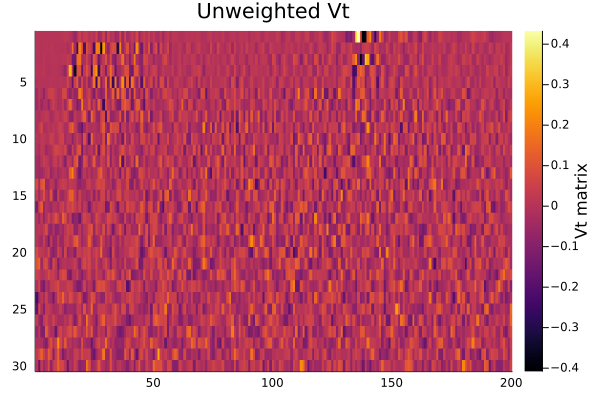

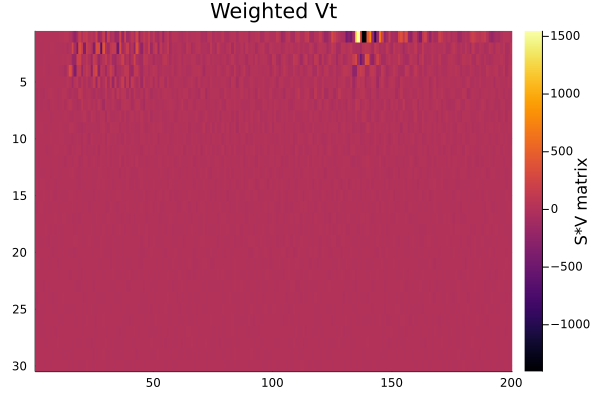

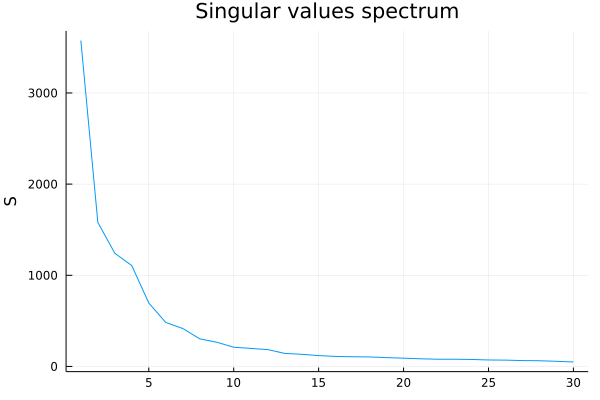

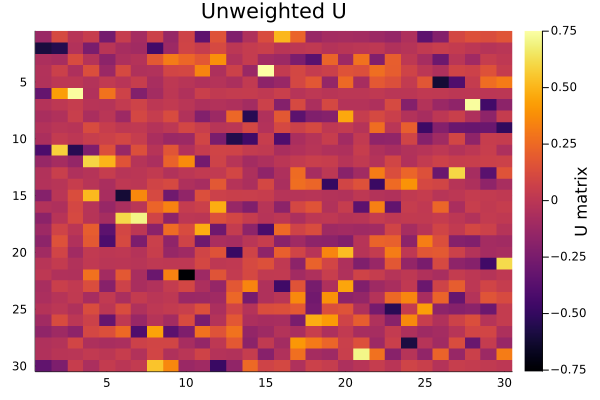

In [76]:
decomposition = svd(seismograms)
U = decomposition.U
S = decomposition.S # The book calls it L. It is provided here already as a vector of the singular values.
V = decomposition.V
Vt = decomposition.Vt # transpose of V

unweighted = heatmap(Vt, title="Unweighted Vt", yflip=true, colorbar_title="Vt matrix")
weighted = heatmap(diagm(S)*Vt, title="Weighted Vt", yflip=true, colorbar_title="S*V matrix")

display(unweighted)
display(weighted)

display(plot(S, title="Singular values spectrum", ylabel="S", legend=false))
display(heatmap(U, title="Unweighted U", yflip=true, colorbar_title="U matrix"))

Now we'll plot various approximations together with the actual result.

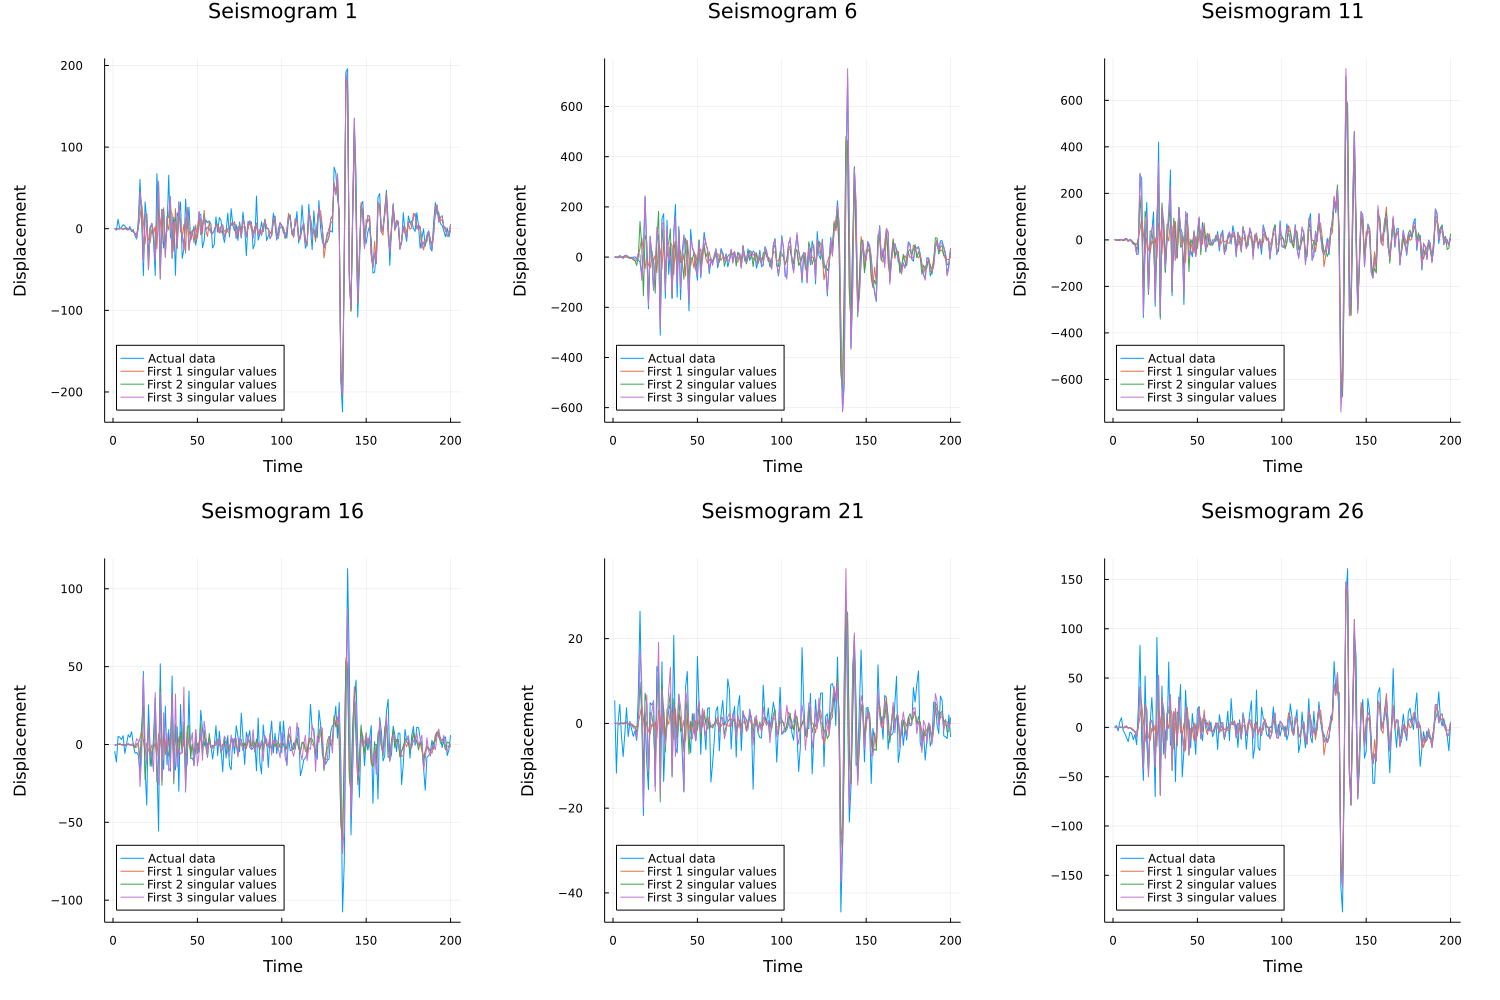

In [130]:
# Just a custom type for storing U_p * S_p * V_p^T
struct ApproxMatrix
    mat::Matrix
    p::Int # First p singular values used to make mat
end

"""
Generate an approximation of the seismogram matrix using the first p singular values
"""
function approximateMatrix(U::Matrix, S::Vector, Vt::Matrix, p::Integer)::ApproxMatrix
    # Truncate component matrices
    Up = U[:,1:p]
    Sp = S[1:p] 
    Vtp = Vt[1:p,:]
    # Save as our custom type
    ApproxMatrix(Up*diagm(Sp)*Vtp, p)
end


"""
Plot a single seismogram (matrix row) with actual value and several p values.
"""
function plotSeismogram(row::Int, actualMatrix::Matrix, approxMatrices::Vector{ApproxMatrix})::Plots.Plot
    actual = actualMatrix[row,:]
    fig = plot(actual, title="Seismogram $row", xlabel="Time", ylabel="Displacement", label="Actual data", legend=:bottomleft)
    for approx in approxMatrices
        plot!(approx.mat[row,:], label="First $(approx.p) singular values")
    end
    return fig
end


# Each element p in this list causes an approximation to be generated with the first p singular values
pValues = [1,2,3]

approxMatrices = approximateMatrix.(Ref(U), Ref(S), Ref(Vt), pValues) # refs mean only pValues is broadcast

plotRange = 1:5:30 # row indicies of the seismograms to display

figures = plotSeismogram.(plotRange, Ref(seismograms), Ref(approxMatrices))

plt = plot(figures..., layout=length(plotRange), size=(1500, 1000), margin=8mm)

display(plt)

In [89]:
function plotApproximations(decomposition::SVD, pValues::Vector{Int}, row::Int, label::String)::Plots.Plot
    U = decomposition.U
    S = decomposition.S # The book calls it L. It is provided here already as a vector of the singular values.
    V = decomposition.V
    Vt = decomposition.Vt # transpose of V

    fig = plot(xlabel="Time", ylabel="Displacement", title=label)

    for p in pValues
        Up = U[:,1:p]
        Sp = S[1:p] # Truncate component matrices
        Vtp = Vt[1:p,:]
        fig = plot!(Up*diagm(Sp)*Vtp, label="First $p singular values")
    end

    return fig
end;

plotApproximations(decomposition, [1], "Test")

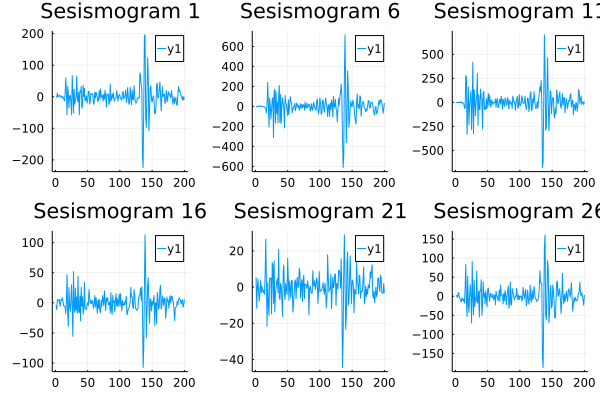

In [84]:
function plotRows(M::Matrix, step::Int)::Plots.Plot
    # Preallocating would be faster but this will make the code simpler
    figures = Vector{Plots.Plot}()

    for i in 1:step:size(M)[1]
        row = M[i,:]
        fig = plot(row, title="Sesismogram $i")
        push!(figures, fig)
    end
    
    plot(figures..., layout=length(figures))
end;

plotRows(seismograms, 5)

In [48]:
"""
Display approximated seismograms.
"""
function ApproximateSeismograms(S::Matrix)::Plots.Plot
    # First perform svd decomposition
    decomposition = svd(seismograms)
    U = decomposition.U
    S = decomposition.S # The book calls it L. It is provided here already as a vector of the singular values.
    V = decomposition.V
    Vt = decomposition.Vt # transpose of V
    
    # Store matrices generated by p values
    # Indice of value = indice of p value used to generate it
    approximatedMatrices = Vector{Matrix}(undef, length(S))

    for p in 1:length(S)
        Up = U[:,1:p]
        Sp = S[1:p] # Truncate component matrices
        Vtp = Vt[1:p,:]
        approximatedMatrices[p] = Up * diagm(Sp) * Vtp
    end

    # use length of range?

    N = 5 # how many p values to plot
    # Print N combiantions of p values, if there are more than five
    ln = length(approximatedMatrices)
    step = ln <= N ? 1 : floor(ln ÷ N) # integer division
    rnge = 1:step:ln

    # generate plot object
    figures = Vector{Plots.Plot}(undef, length(rnge))

    for i in rnge
        M = approximatedMatrices[i]
        figures[i] = plot(M)
    end

    return figures[1]
end


ApproximateSeismograms(seismograms)

LoadError: BoundsError: attempt to access 5-element Vector{Plots.Plot} at index [7]